# TokSearch Tutorial

## Presented by Brian Sammuli, Jan. 29, 2024

# TokSearch

Python package for...
- parallel retrieving
- processing
- filtering 

of arbitrary-dimension fusion experimental data. 

Provides
- High level API for extracting information from many shots
- Useful classes for data retrieval and manipulation.

# Pipeline

- Fundamental class in TokSearch is the ```Pipeline```
- Takes a list of shots and, for each shot in the list, creates a dict-like object called a ```Record```. 

- Provides methods for defining a sequence of processing steps to apply to each record. 

Processing steps include:

- Passing user-defined functions to the pipeline via the ```map``` method.

and...

- Using a set of built-in methods, such as ```fetch```, ```fetch_dataset```, ```align```, ```keep```, or ```discard```.

and...

- ```where``` method, takes as input a user-defined filtering function, removes record from pipeline if evaluates to False



# Documentation

This tutorial is abbreviated version of material available at

https://diii-d.gat.com/DIII-D/software/ml/toksearch/latest/

# Using existing installation

On saga cluster at GA

```bash
module load toksearch
```

# Setting Up Your Own Conda Environment 

On saga cluster

```bash
module load toksearch/base
```

Create a new environment in /path/to/some/dir with toksearch installed

```bash
mamba create -p /path/to/some/dir -c $TOKSEARCH_CHANNEL -c conda-forge toksearch
```

# Simple example

Basic workflow:
- Define a set of ```Signal``` objects which represent, for example, MDSplus or PTDATA pointnames. 
- In this case...
    - Plasma current ```ip```, from PTDATA
    - Calculated plasma current ```ipmhd```, from the efit01 MDSplus tree.

In [50]:
from toksearch import PtDataSignal, MdsSignal

ip_signal = PtDataSignal('ip')
ipmhd_signal = MdsSignal(r'\ipmhd', 'efit01')

Aside on DIII-D data:
- Two primary data archives:
    - PTDATA - Bulk of data. Mostly raw signals from digitizers (with physics calibration factors). Bespoke format implemented at DIII-D (dates from 1980s)
    - MDSplus - At DIII-D, stores mostly processed data (e.g. equilibria). Used widely in physics community.

Next, instantiate a ```Pipeline``` object with a list of the shots that we want to process.

In [51]:
from toksearch import Pipeline

shots = [165920, 165921]
pipeline = Pipeline(shots)

Specify signals to grab using ```fetch``` method

(Note that execution is lazy and deferred until explicitly requested - more later) 

In [52]:
pipeline.fetch('ip', ip_signal)
pipeline.fetch('ipmhd', ipmhd_signal)

Now execute the pipeline.

Three choices

- ```pipeline.compute_serial```: Process each shot serially
- ```pipeline.compute_spark```: Process shots in parallel with Apache Spark
- ```pipeline.compute_ray```: Process shots in parallel with Ray

All ```compute*``` methods return list-like object containing resulting sequence of ```Record``` objects.

In [53]:
records = pipeline.compute_serial()
print('Number of records: {}. Should be 2.'.format(len(records)))

Number of records: 2. Should be 2.


Let's now take a look at the results.

In [55]:
import numpy as np
import collections
import pprint
np.set_printoptions(threshold=3, precision=1)


# Helper function for printing results
def pretty_print(record, level=0):    
    print("*"*80)
    for key in record.keys():
        val = record[key]
        if isinstance(val, collections.Mapping):
            print('{}:'.format(key))
            for subkey, subval in val.items():
                print('\t{}: {}'.format(subkey, subval))
        else:
           print('{}: {}'.format(key, val))

In [56]:
            
# Note the list-like behavior of the records result
for record in records:
    pretty_print(record) # Definition suppressed for slide show

********************************************************************************
shot: 165920
errors:
ip:
	n_over: 0
	n_under: 0
	data: [-1391.2  -463.7   154.6 ...  -463.7 -1391.2 -2318.7]
	times: [ -996.   -995.5  -995.  ... 14362.5 14363.  14363.5]
	units: {'data': 'amps', 'times': 'ms'}
	dims: ('times',)
ipmhd:
	data: [213493.6 281801.6 286739.6 ... 475302.8 474772.5 471811.7]
	units: {'data': 'A', 'times': 'ms'}
	times: [ 100.  140.  160. ... 6340. 6360. 6380.]
	dims: ('times',)
********************************************************************************
shot: 165921
errors:
ip:
	n_over: 0
	n_under: 0
	data: [  1391.2      0.  -10511.6 ...  -2164.2  -1236.7   -927.5]
	times: [ -996.   -995.5  -995.  ... 14362.5 14363.  14363.5]
	units: {'data': 'amps', 'times': 'ms'}
	dims: ('times',)
ipmhd:
	data: [213254.  282727.8 286100.  ... 485212.5 483553.4 481211.4]
	units: {'data': 'A', 'times': 'ms'}
	times: [ 100.  140.  160. ... 6340. 6360. 6380.]
	dims: ('times',)


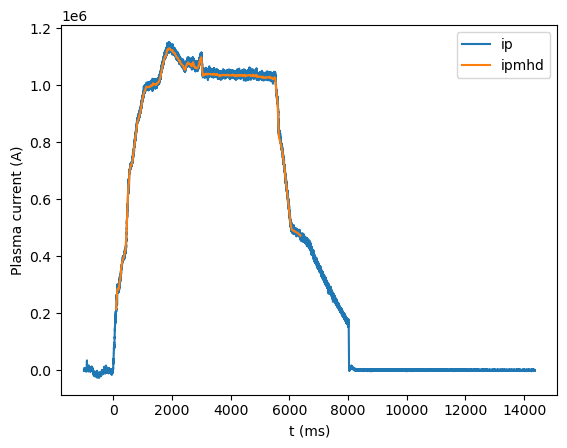

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

rec = records[0]
fig, ax = plt.subplots()
for sig in ["ip", "ipmhd"]:
    d = rec[sig]["data"]
    t = rec[sig]["times"]
    ax.plot(t, d, label=sig)
ax.set_xlabel("t (ms)")
ax.set_ylabel("Plasma current (A)")

_ = ax.legend()

In [7]:
pretty_print(records[0])

********************************************************************************
shot: 165920
errors:
ip:
	n_over: 0
	n_under: 0
	data: [-1391.2  -463.7   154.6 ...  -463.7 -1391.2 -2318.7]
	times: [ -996.   -995.5  -995.  ... 14362.5 14363.  14363.5]
	units: {'data': 'amps', 'times': 'ms'}
	dims: ('times',)
ipmhd:
	data: [213493.6 281801.6 286739.6 ... 475302.8 474772.5 471811.7]
	units: {'data': 'A', 'times': 'ms'}
	times: [ 100.  140.  160. ... 6340. 6360. 6380.]
	dims: ('times',)


Some things to note about the result:

- Each ```Record``` object will always contain two attributes: ```shot``` and ```errors```. 
- ```errors``` is a dictionary that stores information exceptions for that shot. Empty dict means no errors.
- Recall that when calling ```pipeline.fetch(...)```, we specified the labels 'ip' and 'ipmhd'. Those show up in the results records as fields. 
- Default behavior for the ```fetch``` operation is to return a dictionary with the fields ```data``` and ```times```, each of which is a numpy array.

Now, let's do something slightly more interesting...

- Define a custom processing function
- Add it to the pipeline using ```map``` method
    - Applied to each ```Record``` in the pipeline

Define function, ```max_currents```, calculate the maximum absolute value of both ```ip``` and ```ipmhd```. 

Functions passed to ```map``` take a single ```Record``` object as input, modify that object in place (returning nothing).

In [8]:
@pipeline.map
def max_currents(record):
    record['max_ip'] = np.max(np.abs(record['ip']['data']))
    record['max_ipmhd'] = np.max(np.abs(record['ipmhd']['data']))

Note that we're using the decorator formulation of ```max_currents```. We could equivalently have done this:

```python
def max_currents(record):
    record['max_ip'] = np.max(np.abs(record['ip']['data']))
    record['max_ipmhd'] = np.max(np.abs(record['ipmhd']['data']))
    
pipeline.map(max_currents)
```

Let's run ```compute_serial``` again and examine the results:

In [9]:
records = pipeline.compute_serial()

for record in records:
    pretty_print(record)

********************************************************************************
shot: 165920
errors:
ip:
	n_over: 0
	n_under: 0
	data: [-1391.2  -463.7   154.6 ...  -463.7 -1391.2 -2318.7]
	times: [ -996.   -995.5  -995.  ... 14362.5 14363.  14363.5]
	units: {'data': 'amps', 'times': 'ms'}
	dims: ('times',)
ipmhd:
	data: [213493.6 281801.6 286739.6 ... 475302.8 474772.5 471811.7]
	units: {'data': 'A', 'times': 'ms'}
	times: [ 100.  140.  160. ... 6340. 6360. 6380.]
	dims: ('times',)
max_ip: 1152410.4080200195
max_ipmhd: 1129914.0
********************************************************************************
shot: 165921
errors:
ip:
	n_over: 0
	n_under: 0
	data: [  1391.2      0.  -10511.6 ...  -2164.2  -1236.7   -927.5]
	times: [ -996.   -995.5  -995.  ... 14362.5 14363.  14363.5]
	units: {'data': 'amps', 'times': 'ms'}
	dims: ('times',)
ipmhd:
	data: [213254.  282727.8 286100.  ... 485212.5 483553.4 481211.4]
	units: {'data': 'A', 'times': 'ms'}
	times: [ 100.  140.  160. ... 6340.

The two records now have the fields ```max_ip``` and ```max_ipmhd``` as expected.

Suppose we don't care about keeping signal data after calculating ```max_ip``` and ```max_ipmhd```

Or, maybe we have limited memory

- Use ```keep``` or ```discard``` methods

In [10]:
pipeline.keep(['max_ip', 'max_ipmhd'])

records = pipeline.compute_serial()
for record in records:
    pretty_print(record)

********************************************************************************
shot: 165920
errors:
max_ip: 1152410.4080200195
max_ipmhd: 1129914.0
********************************************************************************
shot: 165921
errors:
max_ip: 1143908.3862304688
max_ipmhd: 1124894.625


Note that the ```ip``` and ```ipmhd``` fields are no longer present in the records.

Now suppose that we want only shots for which the maximum ```ip``` is above 1.15 MA. 

- Create user-defined function that takes a ```Record``` and returns a truthy value (e.g. boolean). 
    - Add function to pipeline using ```where``` method



In [11]:
@pipeline.where
def max_ip_is_high_enough(record):
    return record['max_ip'] > 1.15e6

- When run by pipeline, if function returns ```False``` record will be removed from the pipeline.

In [12]:
records = pipeline.compute_serial()
print('len(records): {}. Should be 1.'.format(len(records)))


for record in records:
    pretty_print(record)

len(records): 1. Should be 1.
********************************************************************************
shot: 165920
errors:
max_ip: 1152410.4080200195
max_ipmhd: 1129914.0


Only one of the two input shots (165920) matched the where criteria, so the length of ```records``` is 1.

In [13]:
%reset -f


# Parallelization

- The ```compute_serial``` method processes each shot in the ```Pipeline``` sequentially. 
    - Ok for small problems. 
- For big problems, take advantage of embarassingly parallel nature of episodic shots

Currently support two distributed computing frameworks:

1. [Apache Spark](https://spark.apache.org/)
2. [Ray](https://ray.readthedocs.io/en/latest/)

Both frameworks offer similar capabilities and performance when used with TokSearch. 
- Allow both single machine and fully distributed, multi-node paralleization

Let's re-visit the previous example, but with more shots.

Putting everything together...

In [14]:
from toksearch import Pipeline
from toksearch import MdsSignal, PtDataSignal
    
def create_pipeline(shots):
    ipmhd_signal = MdsSignal(r'\ipmhd', 'efit01')
    ip_signal = PtDataSignal('ip')

    pipeline = Pipeline(shots)
    pipeline.fetch('ipmhd', ipmhd_signal)
    pipeline.fetch('ip', ip_signal)
    
    @pipeline.map
    def max_currents(record):
        record['max_ip'] = np.max(np.abs(record['ip']['data']))
        record['max_ipmhd'] = np.max(np.abs(record['ipmhd']['data']))
    
    
    @pipeline.where
    def max_ip_is_high_enough(record):
        return record['max_ip'] > 1.15e6
    
    pipeline.keep(['max_ipmhd'])
    return pipeline

In [15]:
import time

import numpy as np

# Context manager that we can use to time execution
class Timer(object):
    def __init__(self):
        self.start = None
        
    def __enter__(self):
        self.start = time.time()
        
    def __exit__(self, *args):
        elapsed = time.time() - self.start
        print('---------------------')
        print(f'---> Ran in {elapsed:.2f} s')

Now we specify a non-trivial number of shots and create a list of shot numbers.

In [16]:
num_shots = 500
shots = list(range(165920, 165920+num_shots))

First run with compute_serial

In [22]:
with Timer():
    pipeline = create_pipeline(shots)
    records = pipeline.compute_serial()
    
print(f"Num records: {len(records)}")

---------------------
---> Ran in 17.47 s
Num records: 195


Now run with compute_ray

In [23]:
with Timer():
    pipeline = create_pipeline(shots)
    records = pipeline.compute_ray()
    
print(f"Num records: {len(records)}")

********************************************************************************
BATCH 1/1
NUM CPUS: 48
NUM PARTITIONS: 500
MEDIAN PARTITION SIZE: 1
---------------------
---> Ran in 1.26 s
Num records: 195


# Fully distributed execution with ```toksearch_submit```

So far, these examples use a single node.

But, we can take advantage of multi-node clusters.


Mechanism for distributing TokSearch computations: ```toksearch_submit``` utility. 
- Uses SLURM behind the scenes
- Supports both interactive and batch modes (ie salloc and sbatch)




\#some_example.py

```python
from toksearch import Pipeline, MdsSignal, PtDataSignal
    
def create_pipeline(shots):
    ...

if __name__ == "__main__":
    shots = list(range(165920, 165920 + 10_000))
    pipeline = create_pipeline(shots)
    records = pipeline.compute_ray()
    print(f"Num records: {len(records)}")
```

From the command line, simply run

```bash
toksearch_submit -N 3 python some_example.py
```

In [26]:
%reset -f

# Using Xarray Datasets with TokSearch

- Xarray dataset --> arbitrary dimension Pandas dataframe

Handles...
1. 0d, time-dependent scalars (e.g. plasma current)
2. 1d, time-dependent profiles (e.g. current profiles)
3. 2d, time-dependent grid data (e.g. flux on the grid)

Create Xarray data using ```fetch_dataset``` method 

e.g.
```python
pipeline.fetch_dataset("ds", {'signal_label': signal_object, ...})
```

Update previous example a bit...

In [27]:
from toksearch import PtDataSignal, MdsSignal, Pipeline

def create_pipeline():
    ip_signal = PtDataSignal('ip')
    ipmhd_signal = MdsSignal(r'\ipmhd', 'efit01')
    shots = [165920, 165921]
    pipeline = Pipeline(shots)
    pipeline.fetch_dataset('ds', {'ip': ip_signal, 'ipmhd': ipmhd_signal})
    return pipeline

pipeline = create_pipeline()
records = pipeline.compute_serial()

In [29]:
print(records[0])

{'shot': 165920, 'errors': {}, 'ds': <xarray.Dataset>
Dimensions:  (times: 30859, shot: 1)
Coordinates:
  * times    (times) float64 -996.0 -995.5 -995.0 ... 1.436e+04 1.436e+04
  * shot     (shot) int64 165920
Data variables:
    ip       (times) float64 -1.391e+03 -463.7 154.6 ... -1.391e+03 -2.319e+03
    ipmhd    (times) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan}


Things to note about this result:

- Each ```Record``` has field called ```ds```, as requested in the call to ```fetch_dataset```.
- Both signals in ```ds``` share a timebase (the ```times``` coordinate). However, because ```ipmhd``` has a much slower sample rate, most of its data is filled with NANs.

# Aligning signals

In previous Xarray example...

Want to make sure the ```times``` dimensions for both signals are aligned, have data at each sample (instead of possibly having a NAN).

Accomplish with ```Pipeline.align``` method.

First define a helper function for running and plotting data from a pipeline...

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

def compute_and_plot(pipeline, xlim=None, ylim=None):
    rec = pipeline.compute_serial()[0]
    ds = rec['ds']
    print(ds)
    plt.plot(ds.ip.times, ds.ip, label='ip')
    plt.plot(ds.ipmhd.times, ds.ipmhd, label='ipmhd')
    plt.xlabel('t (ms)')
    plt.ylabel('Plasma current')
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.legend()

- Align everything in ds with ip using the pad method.
- The pad method looks for the nearest time point in the past and uses that
    - Maintains causality

<xarray.Dataset>
Dimensions:  (times: 30720, shot: 1)
Coordinates:
  * times    (times) float64 -996.0 -995.5 -995.0 ... 1.436e+04 1.436e+04
  * shot     (shot) int64 165920
Data variables:
    ip       (times) float64 -1.391e+03 -463.7 154.6 ... -1.391e+03 -2.319e+03
    ipmhd    (times) float32 2.135e+05 2.135e+05 ... 4.718e+05 4.718e+05


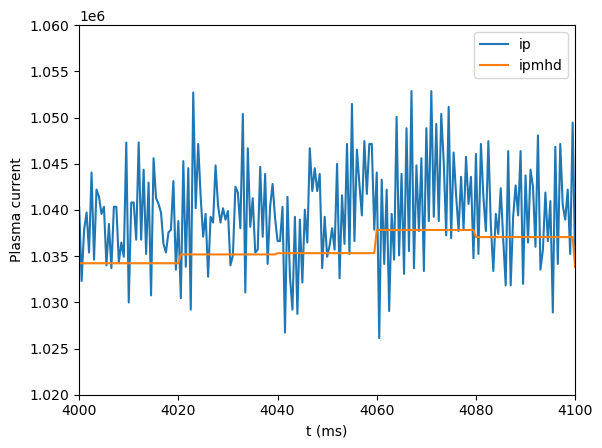

In [35]:
pipeline = create_pipeline()
pipeline.align('ds', 'ip', method='pad')
compute_and_plot(pipeline, xlim=(4000,4100), ylim=(1.02e6, 1.06e6))

Now use linear interpolation to align with ```ip```'s timebase (Be mindful of data leakage!)

<xarray.Dataset>
Dimensions:  (shot: 1, times: 30720)
Coordinates:
  * shot     (shot) int64 165920
  * times    (times) float64 -996.0 -995.5 -995.0 ... 1.436e+04 1.436e+04
Data variables:
    ip       (times) float64 -1.391e+03 -463.7 154.6 ... -1.391e+03 -2.319e+03
    ipmhd    (times) float64 -1.658e+06 -1.657e+06 ... -7.1e+05 -7.101e+05


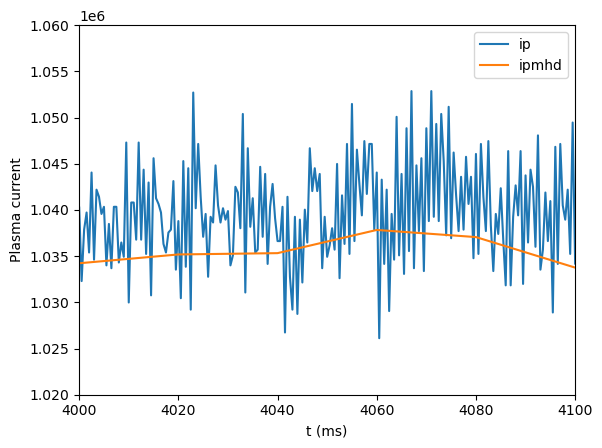

In [36]:
pipeline = create_pipeline()
pipeline.align('ds', 'ip', method='linear')
compute_and_plot(pipeline, xlim=(4000,4100), ylim=(1.02e6, 1.06e6))

Can also align with...
- Pre-defined array
- Callback function


<xarray.Dataset>
Dimensions:  (shot: 1, times: 204)
Coordinates:
  * shot     (shot) int64 165920
  * times    (times) float64 4e+03 4.001e+03 4.001e+03 ... 4.1e+03 4.1e+03
Data variables:
    ip       (times) float64 1.04e+06 1.032e+06 ... 1.049e+06 1.034e+06
    ipmhd    (times) float64 1.034e+06 1.034e+06 ... 1.034e+06 1.034e+06


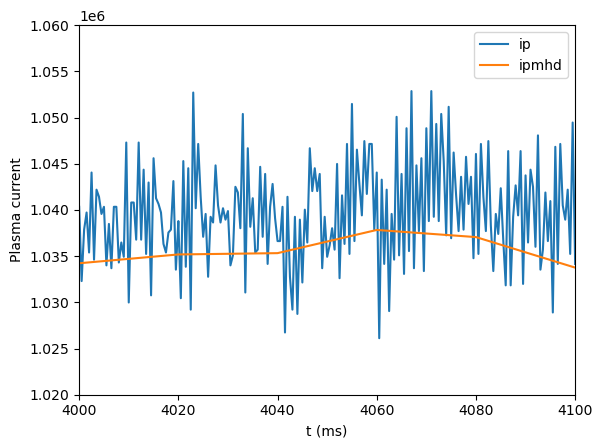

In [37]:
def custom_timebase(ds):
    condition = (ds.times >= 4000) & (ds.times <= 4100)
    return ds.times.where(condition, drop=True)

pipeline = create_pipeline()
pipeline.align('ds', custom_timebase, method='linear')
compute_and_plot(pipeline, xlim=(4000,4100), ylim=(1.02e6, 1.06e6))

In [38]:
%reset -f

# Creating a Pipeline from an SQL Query

 ```Pipeline``` can be instantiated from SQL query 

Alternate constructor (class method) ```Pipeline.from_sql``` 
- Accepts a standard Python DB API connection object and a query + interpolated query parameters

Utility function called ```connect_d3drdb``` connects to DIII-D relational database

In [45]:
from toksearch.sql.mssql import connect_d3drdb
from toksearch import Pipeline
import datetime

# Grab all plasma and data acquisition test shots, sorted by shot number is ascending order
query = """
    select shot, shot_type from shots_type
    where shot_type = 'plasma' or shot_type = 'data acquisition'
    order by shot asc
"""

with connect_d3drdb() as conn:
    pipeline = Pipeline.from_sql(conn, query)

results = pipeline.compute_serial()

print(f'NUM RESULTS: {len(results)}')
print(results[-1])

NUM RESULTS: 99910
{'shot': 197546, 'errors': {}, 'shot_type': 'data acquisition'}


Note that 'shot' and 'shot_type' from query are in ```Record``` now.

Useful for initializing records with external metadata.

# High dimensional signals

Looking at ```psirz``` - Poloidal flux on the grid
- 65 x 65, 2d + time data

(Aside: ```Signal``` objects can be used outside of pipelines)

In [64]:
shot = 165920

dims = ['r', 'z', 'times']
psirz_sig = MdsSignal(r'\psirz', 'efit01', dims=dims)

dict_result = psirz_sig.fetch(shot)
print(f"times: {dict_result['times']}")
print(f"r    : {dict_result['r']}")
print(f"z    : {dict_result['z']}")

times: [ 100.  140.  160. ... 6340. 6360. 6380.]
r    : [0.8 0.9 0.9 ... 2.5 2.5 2.5]
z    : [-1.6 -1.6 -1.5 ...  1.5  1.6  1.6]


Can also fetch into an xarray DataArray

In [65]:
data_order = ['times', 'r', 'z']
psirz_sig = MdsSignal(r'\psirz', 'efit01', dims=dims, data_order=data_order)
da = psirz_sig.fetch_as_xarray(shot)
print(f"times: {da['times']}")
print(f"r    : {da['r']}")
print(f"z    : {da['z']}")

times: <xarray.DataArray 'times' (times: 303)>
array([ 100.,  140.,  160., ..., 6340., 6360., 6380.], dtype=float32)
Coordinates:
  * times    (times) float32 100.0 140.0 160.0 ... 6.34e+03 6.36e+03 6.38e+03
Attributes:
    units:    ms
r    : <xarray.DataArray 'r' (r: 65)>
array([0.84    , 0.866562, 0.893125, 0.919688, 0.94625 , 0.972812, 0.999375,
       1.025937, 1.0525  , 1.079062, 1.105625, 1.132187, 1.15875 , 1.185313,
       1.211875, 1.238437, 1.265   , 1.291563, 1.318125, 1.344687, 1.37125 ,
       1.397812, 1.424375, 1.450938, 1.4775  , 1.504062, 1.530625, 1.557188,
       1.58375 , 1.610312, 1.636875, 1.663437, 1.69    , 1.716563, 1.743125,
       1.769687, 1.79625 , 1.822813, 1.849375, 1.875937, 1.9025  , 1.929063,
       1.955625, 1.982188, 2.00875 , 2.035312, 2.061875, 2.088438, 2.115   ,
       2.141562, 2.168125, 2.194688, 2.22125 , 2.247813, 2.274375, 2.300937,
       2.3275  , 2.354063, 2.380625, 2.407187, 2.43375 , 2.460313, 2.486875,
       2.513438, 2.54    ], dtyp

# Wrapping up

Questions?

Comments?